In [5]:
import h5py
import glob
import numpy as np 
import matplotlib.pyplot as plt
from scipy import signal
import scipy as sp
from scipy.signal import butter
from scipy.optimize import curve_fit
from lmfit.models import GaussianModel

### Import & parameter definitions ###

In [6]:
# reading h5 file
f = h5py.File("20190518_173944_projection-Copy1.h5")
list(f.keys())
shots = f.get("n-shots")
photE = f.get("x-axis")
intense = f.get("y-axis")
spectrum = range(0,len(intense[:,1]-1)) # for parameter redefinition

In [7]:
# Parameters
lpcutoff = 0.005             # Cut-off frequency for low-pass filter
lowpassdata = intense[29,:]  # Spectrum for which we test, to loop over
heightcut = 5                # Height percentage cut we filter peaks by
dx = 0.1                     # NN Distance threshold
sidecut = 5                  # Edge cut percentage threshold
deg = 5                      # Low-pass filter order

### Functions ###

Low-pass smoothening function, returns smoother spectrum

In [40]:
class lowpass:
    # Main Butterworth lp function
    def __init__(self,lowpassdata, lpcutoff):
        self.lowpassdata = lowpassdata
        self.lpcutoff = lpcutoff
    
        b, a = signal.butter(deg, self.lpcutoff, 'low')
        self.spec = signal.filtfilt(b, a, self.lowpassdata)
    
    
    # Other useful data
    def shift(self):                                    # Min of filtered dataset defines shift
        self.shift = min(self.spec)
        return self.shift
    def MaxPeak(self):                                  # Max of filtered dataset
        MaxPeak = max(self.spec)
        return MaxPeak
    def dataRawS(self):                                 # Shifted raw data
        drs = np.array([photE,self.lowpassdata-shift()]).T
        return drs
    def Noise(self):                                    # Noise data
        noise = np.array([photE,self.lowpassdata-self.spec]).T
        return noise
    def IIData(self):                                   # Total shifted spectrum
        IIData = sum(self.spec-shift())
        return IIData
    def IINoise(self):                                  # Total of noise data
        IINoise = sum(self.lowpassdata-self.spec)
        return IINoise
    def IIDataRaw(self):                                # Total of raw spectral values
        IIDataRaw = sum(self.lowpassdata)
        return IIDataRaw
    def data(self):                                     # Full shifted dataset, including x-axis
        self.data = np.array([photE,self.spec-self.shift()]).T
        return self.data
    
    # Plot function
    def plotlowpass(self):                                                     
        plt.plot(photE, self.lowpassdata, label='Raw data')
        plt.plot(photE, self.spec, label='Filtered')
        plt.plot(photE, self.data()[:,1],label = 'Shift adjusted')
        plt.plot(photE, self.Noise()[:,1],label = 'Noise')
        plt.legend()
    

Raw data vs low-pass test

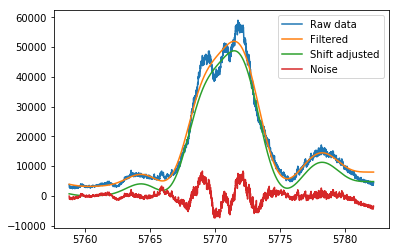

In [41]:
fn = lowpass(lowpassdata,lpcutoff)
fn.plotlowpass()

Preliminary peak finding

In [176]:
class FindPeaks:
    def __init__(self, rawData, cutoff):
        self.rawData = rawData
        self.cutoff = cutoff
        
        # Standard deviation is standard deviation of noise
        fn = lowpass(self.rawData, self.cutoff)
        self.SD = np.std(fn.Noise())
        
        self.Data = fn.data()
        self.h = (max(self.Data[:,1]/(100*heightcut)))
    
    # Finding peaks and positions
    
    def peaks(self):
        p = sp.signal.find_peaks(self.Data[:,1]) # eg with conditions , height=h, distance = self.SD/10
        self.peaks = np.asarray(p)
        return self.peaks
    def pospeaks(self):
        self.pospeaks = np.asarray(np.asarray(self.peaks())[0])
        return self.pospeaks
    def xpeaks(self):
        self.xpeaks = np.asarray(self.Data[self.pospeaks(),0])
        return self.xpeaks
    def ypeaks(self):
        self.ypeaks = np.asarray(self.peaks[0])
        return self.ypeaks
    
    # Peak dataset
    
    def CollectedPeaks(self):
        Peaks = np.array([self.xpeaks,self.ypeaks])
        return Peaks

In [177]:
# When executing, put in condition self.n > 1
# Also return n after putting through filters

class FilterPeaks:
    def __init__(self, rawData, cutoff):
        self.rawData = rawData
        self.cutoff = cutoff
        
        fn = FindPeaks(self.rawData, self.cutoff)
        self.xpeaks = fn.xpeaks()
        self.ypeaks = fn.ypeaks()
        self.n = len(self.xpeaks)
        self.Peaks = fn.CollectedPeaks()
        
    def EliminatePeaks(self):
        peaks = self.Peaks
        for j in range(self.n):
            if np.sort(abs(self.xpeaks-self.xpeaks[j]))[1] < dx:
                peaks = remove(peaks[j])
                self.pospeaks = peaks[:,0]
                self.xpeaks = fn.Data[self.pospeaks,0]
                self.ypeaks = peaks[:,1]
        self.Peaks = np.array([self.xpeaks,self.ypeaks])
        
        # edge peaks elim
        peaks = self.Peaks
        for j in range(self.n):
            if abs(self.xpeaks[j] - max(photE)) < ((max(photE) - min(photE))*sidecut/100) or abs(self.xpeaks[j] - min(photE)) < ((max(photE) - min(photE))*sidecut/100):
                peaks = remove(peaks[j])
                self.pospeaks = peaks[:,0]
                self.xpeaks = fn.Data[self.pospeaks,0]
                self.ypeaks = peaks[:,1]
        self.Peaks = np.array([self.xpeaks,self.ypeaks])
        return self.Peaks

In [187]:
fn = FilterPeaks(lowpassdata,lpcutoff)
if fn.n > 1:
    cond = fn.EliminatePeaks()
n = cond.shape[1]

In [197]:
class Gauss:
    def __init__(self, n, pospeaks, data):
        self.n = n
        self.pospeaks = pospeaks
        self.d = data[:,1]
        self.data = data
        
    def indiv(self):
        oldpos = 0
        fwhm = []
        gaussResults = []
        for i in range(self.n):
        # slicing peaks
            if i != self.n-1:
                minimumy = min(self.d[self.pospeaks[i]:self.pospeaks[i+1]])
                position = np.asarray(np.where(self.d == minimumy))
            else:
                pass
            if i == 0:
                slices = np.array(self.d[:int(position)])
               # plt.plot(photE[:int(position)],slices)
            elif i != n-1:
                slices = np.array(self.d[oldpos:int(position)])
               # plt.plot(photE[oldpos:int(position)],slices)
            else:
                slices = np.array(self.d[int(position):])
               # plt.plot(photE[int(position):],slices)   

            spfs = []
            j = 0
            while j < len(self.d):
                if i == n-1:
                    if j < int(position):
                        spfs = np.append(spfs,0)
                    else:
                        spfs = np.append(spfs,slices[j-oldpos])
                else:
                    if j < int(position) and j >= oldpos:
                        spfs = np.append(spfs,slices[j-oldpos])
                    else:
                        spfs = np.append(spfs,0)
                j = j + 1
            oldpos = int(position)

            mod = GaussianModel()
            pars = mod.guess(spfs, x=self.data[:,0])
            self.out = mod.fit(spfs, pars, x=self.data[:,0])
            fwhm.append(out.params['fwhm'].value)
            print("FWHM width of peak", i,": ",out.params['fwhm'].value)
            print("Sigma of peak", i,": ",out.params['sigma'].value)
            gaussResult = out.best_fit
            if i == 0:
                gaussResults = gaussResult
            else:
                gaussResults = np.vstack((gaussResults,gaussResult))
            #plt.plot(photE,spfs)
            plt.plot(photE,gaussResult)
            globals()["peakwidth%i"%i] = out.params['fwhm'].value
            globals()["sigma%i"%i] = out.params['sigma'].value
            self.plotdata = gaussResults
            return gaussResults
            
    def plotIndiv(self):
        for i in range(self.n):
            func = self.indiv()
            func2 = func.out
            plot = func.plotdata()[i]
            if i == 0:
                plt.plot(photE[:int(position)], plot)
            elif i != n-1:
                plt.plot(photE[oldpos:int(position)], plot)
            else:
                plt.plot(photE[int(position):], plot)
                
            print("FWHM width of peak", i,": ", func2.params['fwhm'].value)
            print("Sigma of peak", i,": ", func2.params['sigma'].value)




FWHM width of peak 0 :  2.5118726315692994
Sigma of peak 0 :  1.0666941131675878
FWHM width of peak 1 :  4.8478143895621475
Sigma of peak 1 :  2.058677261770389
FWHM width of peak 2 :  4.285937905520654
Sigma of peak 2 :  1.8200702837247236


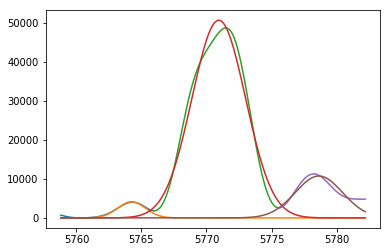

In [198]:
fn1 = lowpass(lowpassdata,lpcutoff)
fn2 = FindPeaks(lowpassdata,lpcutoff)
fn3 = Gauss(n, fn2.pospeaks(),fn1.data())
allofem = fn3.indiv()